In [1]:
import torch
import sys

sys.path.append('..')

import SourceCode

In [15]:
from math import pi, e, sqrt
import torch

from SourceCode.utilities import nth_derivative, plot_two_1d_functions
from SourceCode.EquationClass import MainEquationClass
from SourceCode.DomainClass import OneDimensionalSimpleDomain
from SourceCode.InitConditionClass import OnePointInitialCondition
from SourceCode.IntegralEquations import IntegralEquations
from SourceCode.TrainerForNNEquationSolver import TrainerForNNEquationSolver
from SourceCode.ReportMaker import ReportMaker
import time

n_epochs = 10
n_points = 10
dh = 1e-3

# № 1

$$ y'(x) = \int_{0}^x(x-t)y(t)dt - 1$$
$$y(0)=1$$
$$ true\_sol = e^{-\frac{x}{2}}(cos(\frac{\sqrt{3}}{2}x) - \frac{1}{\sqrt{3}}sin(\frac{\sqrt{3}}{2}x)) $$

In [9]:
left_border = 0
right_border = 1
integration_func = lambda curr_v, int_domain, nn_model: (curr_v - int_domain)*nn_model(int_domain)
main_eq_residual = (
    lambda x, nn_model: nth_derivative(nn_model(x), x, 1)
    - IntegralEquations.calculateVolterraEquation1D(
        integration_func,
        nn_model,
        x,
        left_border,
        right_border,
        n_points) + torch.tensor([1.0], requires_grad=True))
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_border + dh, right_border, n_points)


first_init_cond_res = lambda x, nn_model: nn_model(x) - torch.tensor([1.0], requires_grad=True)
first_init_cond = OnePointInitialCondition(left_border, first_init_cond_res)

boundary_conditions = [first_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residual, boundary_conditions)


n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq)
loss_train, loss_valid, nn_model = nn_ode_solver.fit()

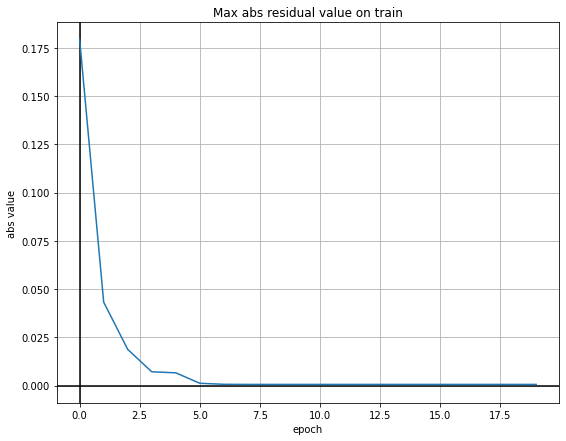

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.0008234530687332153
Valid max absolute error |Appr(x)-y(x)|: 0.0008117854595184326
MAPE on train data: 0.09029339998960495 %
MAPE on validation data: 0.09398325928486884 %
Max abs value of residual on train at last epoch: 0.0005604028701782227 


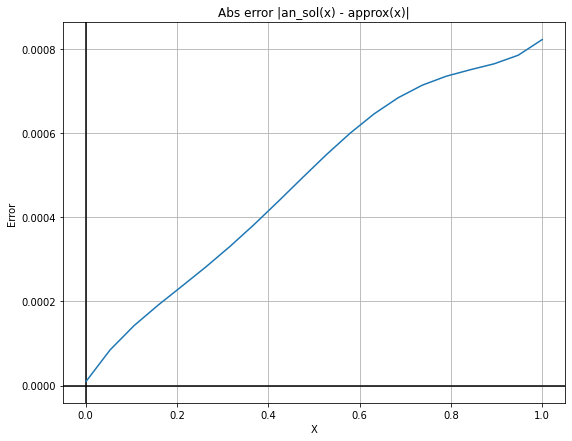

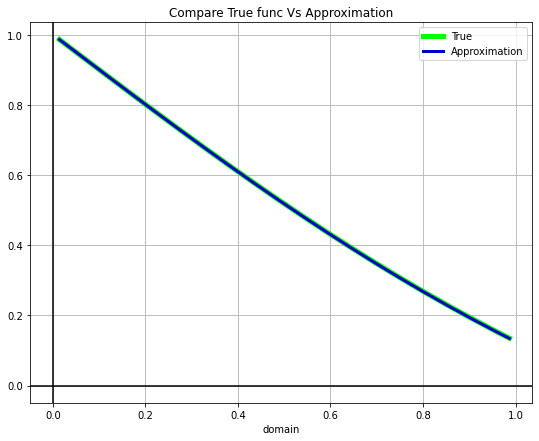

In [17]:
analytical_solution = lambda x: torch.exp(-x / 2) * (torch.cos(sqrt(3)/2*x) - torch.sin(sqrt(3)/2*x)/sqrt(3))
report = ReportMaker(nn_model,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_1d_functions,
                         analytical_solutions=analytical_solution
                         )
report.print_loss_history()
report.compare_appr_with_analytical()